In [73]:
import torch
import pyro
from pyro.distributions import *
from collections import Counter
import pyro.infer
import pyro.optim
pyro.enable_validation(True)
import matplotlib.pyplot as plt
import tqdm
import pandas as pd

In [74]:
#nchords = 10
npcs = 4*7+1 # around C: Cbb to C## on LoF

#@pyro.infer.config_enumerate
def chord_model(npcs, nharmonies, nchords, pobserve=0.5):
    # parameters priors:
    # distribution of the harmonies
    p_harmony = pyro.sample('p_harmony', Dirichlet(0.5 * torch.ones(nharmonies)))
    # distribution of ornament probability
    p_is_chordtone = pyro.sample('p_is_chordtone', Beta(1, 1))
    # distribution of notes in the harmonies
    with pyro.plate('harmonies', nharmonies):
        # distribution of notes per note type
        p_chordtones = pyro.sample('p_chordtones', Dirichlet(0.5 * torch.ones(npcs)))
        p_ornaments  = pyro.sample('p_ornaments', Dirichlet(0.5 * torch.ones(npcs)))
        # we build a big categorical out of the chordtones and ornaments,
        # including notes of unknown type (marginalizing over the categories)
        p_ct = p_is_chordtone       * p_chordtones
        p_or = (1 - p_is_chordtone) * p_ornaments
        p_unobserved = p_ct + p_or
        p_tones = torch.cat([pobserve * p_ct, pobserve * p_or, (1-pobserve) * p_unobserved], dim=1)
    # distribution of note rate in chords
    rate_notes = pyro.sample('rate_notes', Gamma(3,1))
    
    # sampling the data:
    chords = list()
    for c in pyro.plate('data', nchords):
        # pick a harmony
        h = pyro.sample('h_{}'.format(c), Categorical(p_harmony))
        # pick a number of notes
        nnotes = 1 + int(pyro.sample('n_{}'.format(c), Poisson(rate_notes)))
        # sample chordtones
        chordtones = pyro.sample('chord_{}'.format(c), Multinomial(nnotes, p_tones[h]))
        chords.append({'h': h, 'n': nnotes,
                       'counts': chordtones.reshape((npcs,3))})
    return chords

In [77]:
tr = pyro.poutine.trace(chord_model).get_trace(npcs,3,4)
for (name, val) in tr.nodes.items():
    print(name)

_INPUT
p_harmony
p_is_chordtone
harmonies
p_chordtones
p_ornaments
rate_notes
data
h_0
n_0
chord_0
h_1
n_1
chord_1
h_2
n_2
chord_2
h_3
n_3
chord_3
_RETURN


In [78]:
def chord_guide(npcs, nharmonies, nchords, pobserve=0.5):
    # posterior of p_harmony
    params_p_harmony = pyro.param('params_p_harmony', 0.5 * torch.ones(nharmonies),
                                  constraint=constraints.positive)
    pyro.sample('p_harmony', Dirichlet(params_p_harmony))
    # posteriors of notes dists in harmonies
    with pyro.plate('harmonies', nharmonies):
        params_p_chordtones = pyro.param('params_p_chordtones', 0.5 * torch.ones(npcs),
                                         constraint=constraints.positive)
        pyro.sample('p_chordtones', Dirichlet(params_p_chordtones))
        params_p_ornaments = pyro.param('params_p_ornaments', 0.5 * torch.ones(npcs),
                                         constraint=constraints.positive)
        pyro.sample('p_ornaments', Dirichlet(params_p_ornaments))
    # posterior of note rate
    alpha_rate_notes = pyro.param('alpha_rate_notes', torch.tensor(3.),
                                  constraint=constraints.positive)
    beta_rate_notes = pyro.param('beta_rate_notes', torch.tensor(1.),
                                 constraint=constraints.positive)
    rate_notes = pyro.sample('rate_notes', Gamma(alpha_rate_notes, beta_rate_notes))
    # posterior of ornament probability
    alpha_p_ict = pyro.param('alpha_p_ict', torch.tensor(1.), constraint=constraints.positive)
    beta_p_ict = pyro.param('beta_p_ict', torch.tensor(1.), constraint=constraints.positive)
    pyro.sample('p_is_chordtone', Beta(alpha_p_ict, beta_p_ict))

In [79]:
pyro.clear_param_store()
chord_guide(npcs, 3, 4)

In [81]:
chord_model(npcs, 3, 4)

[{'h': tensor(0),
  'n': 3,
  'counts': tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 1.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]])},
 {'h': tensor(0),
  'n': 5,
  'counts': tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
         

In [82]:
def chord_tensor(notes):
    notetype = {'chordtone': 0, 'ornament': 1, 'unknown': 2}
    chord = torch.zeros((npcs, 3))
    for (pitch, t) in notes:
        chord[pitch%npcs, notetype[t]] += 1
    return chord

def annot_data_obs(chords):
    obs = {}
    for (i, chord) in enumerate(chords):
        obs["h_{}".format(i)] = torch.tensor(chord["label"])
        obs["n_{}".format(i)] = torch.tensor(len(chord["notes"]) - 1.)
        obs["chord_{}".format(i)] = chord_tensor(chord["notes"]).flatten()
    return obs

In [83]:
example_chords = [
    {'label': 0, 'notes': [(0,'chordtone'), (4,'chordtone'), (1,'chordtone'), (4,'ornament')]},
    {'label': 1, 'notes': [(0,'chordtone'), (-3,'chordtone'), (1,'chordtone'), (-2,'unknown')]}
]
example_obs = annot_data_obs(example_chords)
example_obs

{'h_0': tensor(0),
 'n_0': tensor(3.),
 'chord_0': tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'h_1': tensor(1),
 'n_1': tensor(3.),
 'chord_1': tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.])}

In [84]:
conditioned_model = pyro.condition(chord_model, data=example_obs)

100%|██████████| 5000/5000 [00:44<00:00, 113.51it/s]


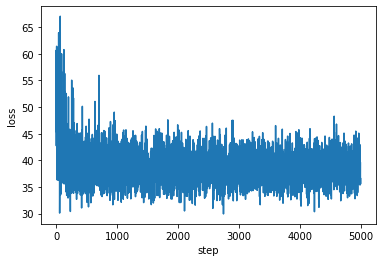

In [88]:
# inference
pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_model,
                     guide=chord_guide,
                     optim=pyro.optim.Adam({"lr": 0.005, "betas": (0.95, 0.999)}),
                     loss=pyro.infer.Trace_ELBO())

losses = []
chord_guide(npcs, 3, 2) # collect params
param_values = {name:[] for name in ['alpha_rate_notes', 'beta_rate_notes', 'alpha_p_ict', 'beta_p_ict']}

nsteps = 5000
for i in tqdm.trange(nsteps):
    losses.append(svi.step(npcs, 3, 2))
    for (name, value) in pyro.get_param_store().items():
        if name in param_values:
            param_values[name].append(value.item())

plt.plot(losses)
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

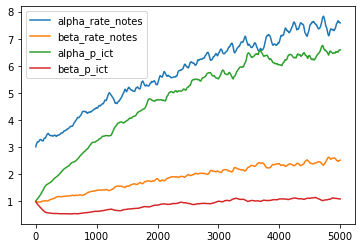

In [90]:
df = pd.DataFrame(param_values)
df.plot()

In [89]:
# show optimized parameters:
for (name, value) in pyro.get_param_store().items():
    print(name, ":\t", value)

params_p_harmony :	 tensor([1.5144, 1.4922, 0.5056], grad_fn=<AddBackward0>)
params_p_chordtones :	 tensor([1.1966, 0.4910, 0.4985, 1.1620, 0.5134, 0.4885, 0.4955, 0.5230, 0.5013,
        0.4776, 0.5141, 0.5090, 0.8194, 0.8614, 0.4922, 0.4898, 0.5079, 0.4980,
        0.4923, 0.4879, 0.7601, 0.4544, 0.5185, 0.4993, 0.4959, 0.6885, 0.5110,
        0.4861, 0.5117], grad_fn=<AddBackward0>)
params_p_ornaments :	 tensor([0.4967, 0.4804, 0.5002, 0.5123, 0.5225, 0.4949, 0.4794, 0.4979, 0.4639,
        0.5259, 0.4917, 0.4992, 0.4747, 0.4856, 0.4949, 0.4794, 0.5030, 0.4902,
        0.4605, 0.5066, 0.5483, 0.4818, 0.4838, 0.5184, 0.5082, 0.5169, 0.4800,
        0.5118, 0.5171], grad_fn=<AddBackward0>)
alpha_rate_notes :	 tensor(7.5852, grad_fn=<AddBackward0>)
beta_rate_notes :	 tensor(2.5182, grad_fn=<AddBackward0>)
alpha_p_ict :	 tensor(6.5894, grad_fn=<AddBackward0>)
beta_p_ict :	 tensor(1.0893, grad_fn=<AddBackward0>)
